In [255]:
import pandas as pd
from collections import Counter
import numpy as np
%matplotlib inline
from collections import Counter

In [256]:
df = pd.read_csv("./astro_tag_exif_autotags_clean_quality_datetimes_photo-url_views_faves.csv")

In [257]:
df.columns

Index([u'local_path', u'id', u'user_nid', u'date_taken', u'capture_device',
       u'lon', u'lat', u'autotags', u'ISO', u'shutter', u'aperture', u'focal',
       u'count', u'modelyear', u'type', u'stype', u'size', u'emp', u'make',
       u'date', u'year', u'month', u'isoweekday', u'hour', u'secpast',
       u'photo_url', u'views', u'faves'],
      dtype='object')

#### Density estimation

In [258]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

In [259]:
df = df[df.lat.notnull()]

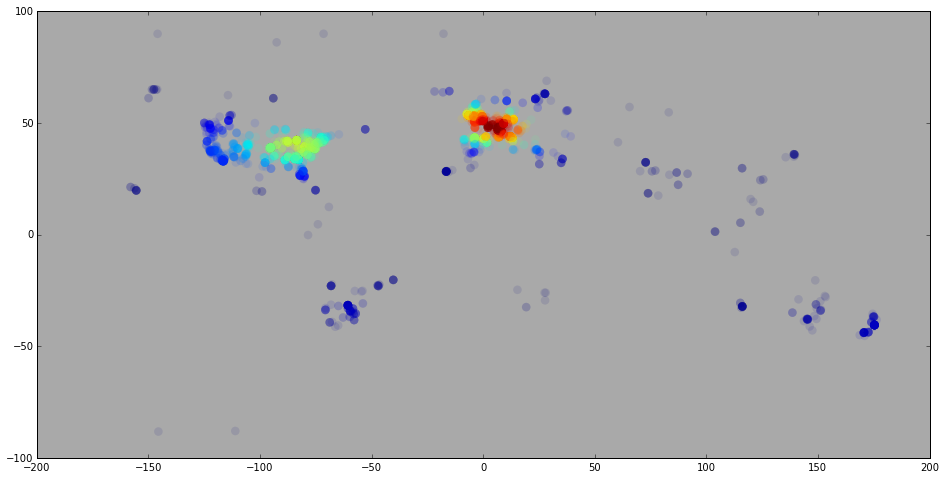

In [260]:
xy = np.vstack([df.lon,df.lat])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df.lon, df.lat, c=z, s=75, edgecolor='',alpha=0.1)
ax.set_axis_bgcolor('darkgrey')

In [261]:
from shapely.geometry import Point

In [262]:
df.reset_index(drop=True,inplace=True)

In [263]:
geopoint = []
for i in range(len(df)):
    geopoint.append(Point(df.lon.loc[i],df.lat.loc[i]))

In [264]:
df['density'] = z
df['geopoint'] = geopoint

In [265]:
df[['geopoint','density','user_nid']].sort('density',ascending=False).head(8)

,geopoint,density,user_nid
3221,POINT (3.941631 49.019915),0.000701,33346666@N07
3206,POINT (3.941802 49.019968),0.000701,33346666@N07
3220,POINT (3.94162 49.020175),0.000701,33346666@N07
3217,POINT (4.026718 49.188659),0.000700,33346666@N07
3223,POINT (4.022254 49.191464),0.000700,33346666@N07
3218,POINT (4.029529 49.231008),0.000699,33346666@N07
3215,POINT (4.029529 49.231008),0.000699,33346666@N07
3219,POINT (4.165935 49.272984),0.000699,33346666@N07


Okay here's the strategy. We want to find the peaks. So, what's a peak? It's not just the highest values. Because around a very high peak, there will be points taller than peaks elsewhere. And we see this is true in the little excerpt of df above. We know there are peaks in various places on the map, but our leaderboard is all in one place (and all from one user, as it turns out).

So, we iterate through a list sorted by density, highest first. Start with row zero. If the point at row one is farther than some stipulated distance, we say it's a new peak. As we go on, we make sure the point we are considering for peakhood is both far enough away from the previous point, and from all points added to the list of peaks. This ensures that we get a good spread of peaks, and that we aren't just finding the highest peak and all its homeboys. If we exceed our limit # peaks with the stipulated distance, we increase the distance and run it again. 

I ran the function below trying for 4 peaks, but the problem is that when 4 peaks is a _max_, the distance gets so high that what we have left aren't really "peaks" in the sense we want. So, what I do instead is let it find, say, 10 peaks, and then just take the highest of those 10. This way, we don't push the distance up too high. The results with this approach were excellent: they gave us a good spread of high peaks. 

Really, what we did was take the 4 highest peaks from some criterion we were okay with.

In [159]:
def density_peaks(num_peaks,crit_init):
    tmp = df.sort('density',ascending=False)
    
    crit_dist = crit_init
    peaks = num_peaks + 1
    
    while peaks > num_peaks:
        peak_list = []
        counter=-1
        for idx in tmp.index:
            counter+=1
            if counter==0:
                peak_list.append(idx)
            else:
                pos_idx = list(tmp.index).index(idx)
                pt = tmp.geopoint.loc[idx]
                prev_pt = tmp.geopoint.loc[tmp.index[pos_idx-1]]
                dist = pt.distance(prev_pt)
                if dist >= crit_dist:
                    if all(pt.distance(df.geopoint.loc[peak]) >= crit_dist for peak in peak_list):
                        peak_list.append(idx)
        
        if len(peak_list) < num_peaks:
            print len(peak_list)
            peaks = len(peak_list)
        elif len(peak_list)==num_peaks:
            peaks = len(peak_list)
        else:
            crit_dist+=1
            print len(peak_list)
    return peak_list

In [160]:
density_peaks(10,50)

11
11
11
11
11
11
11
11
11
11


[3221, 2059, 1766, 2152, 1764, 3457, 1783, 3656, 3892, 3893]

In [161]:
#df[['lat','lon']].loc[[3221, 2059, 1766, 2152, 1764, 3457, 1783, 3656, 3892, 3893]].to_csv("./peaks.csv",index=False)

In [162]:
peak_idxs = [3221, 2059, 1766, 2152, 1764, 3457, 1783, 3656, 3892, 3893]

### Hotspots

Okay we've got 10 peaks. After looking at them, I think we will only use 8. But now, we need to draw a boundary around the peaks and collect all the datapoints inside. There are different ways we could go about this, but I think that I'd like to use a land area of the same size in each case. Unfortunately, that's not a straightforward task, because degrees of longitude do not cover the same mileage everywhere on the globe. Because of the convergence of the meridians at the poles, degrees of longitude there cover a much smaller distance. Accordingly, if we are to get the same land area in every case, we will need to have wide ellipses for those hotspots nearer the poles, and perfect circles at the equator (we could do rectangles, but eh). 

I don't know yet how many points we will grab, given some mileage, so we'll have to try a few different settings. We want to make sure that all 8 hotspots have enough photographs to do a suitable analysis. Our approach is this:

1. Find, for each hotspot, the ratio between the major and minor axes of the ellipse
2. Write a function to generate points on an ellipse with this ratio (with an arbitrary radius)
3. Create a "polygon" with these points using shapely.geometry
4. Do a spatial join to discover which data points are inside each ellipse
5. Repeat until each hotspot has enough datapoints
6. Then compute the distance of each point within the ellipse to its center (the peak)
7. Find a normal weight vector to make a Gaussian sample of these points centered at the peak
8. Profit!

In [163]:
# Latitude: 1 deg = 110.574 km
# Longitude: 1 deg = 111.320*cos(latitude) km

# we need radians...

In [164]:
peaks = df[['lat','lon']].loc[[3221, 2059, 1766, 2152, 1764, 3457, 1783, 3656]] # just top 8

In [165]:
peaks['lat_rad'] = peaks.lat.apply(np.radians)

In [166]:
peaks['lon_km'] = [111.320 * np.cos(item) for item in peaks.lat_rad]

In [167]:
peaks['ratio'] = [110.574 / item for item in peaks.lon_km]

In [168]:
#  (x - lon(peak))^2      (y - lat(peak))^2
#  -----------------  +   -----------------  =  1
#        a^2                    b^2        

#  (x - lon(peak))^2      (y - lat(peak))^2
#  -----------------  +   -----------------  =  1
#    (b * ratio)^2              b^2        

In [169]:
# So now let's define a function to produce points

In [170]:
peaks

,lat,lon,lat_rad,lon_km,ratio
3221,49.019915,3.941631,0.855559,73.003285,1.514644
2059,40.105833,-82.827334,0.699979,85.143750,1.298674
1766,-41.337106,174.810075,-0.721469,83.583124,1.322923
2152,-32.994374,-60.609211,-0.575860,93.366760,1.184297
1764,28.736054,77.123079,0.501539,97.610252,1.132811
3457,19.824385,-155.477871,0.346001,104.722789,1.055873
1783,34.892272,139.139750,0.608985,91.307897,1.211002
3656,-29.442101,27.702970,-0.513862,96.943340,1.140604


In [171]:
step = 0.1

In [172]:
def genpts(b,ratio,lon,lat):
    y = list(np.arange(lat-b,lat+b,step)) # assigning lat points
    a = b * ratio
    
    x = []
    
    for val in y:
        
        if np.random.choice([1,-1],1)[0] == 1:
            tmp = lon + np.sqrt( a**2 - (((val-lat)**2 * a**2) / b**2) )
        else:
            tmp = lon - np.sqrt( a**2 - (((val-lat)**2 * a**2) / b**2) )
        
        x.append(tmp)
        
    x_plus = list(np.arange(lon-a,lon+a,step)) # assigning lon points
    
    for val in x_plus:
        
        if np.random.choice([1,-1],1)[0] == 1:
            tmp = lat + np.sqrt( b**2 - (((val-lon)**2 * b**2) / a**2) )
        else:
            tmp = lat - np.sqrt( b**2 - (((val-lon)**2 * b**2) / a**2) )
        
        y.append(tmp)
    
    x.extend(x_plus)
        
    return [x,y]

In [173]:
b = 1
ratio = peaks.ratio.loc[3221]
lon = peaks.lon.loc[3221]
lat = peaks.lat.loc[3221]

In [174]:
x = genpts(b,ratio,lon,lat)[0]
y = genpts(b,ratio,lon,lat)[1]

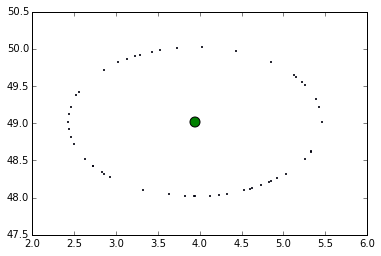

In [175]:
fig,ax = plt.subplots()
ax.scatter(x,y,s=1)
ax.scatter(lon,lat,s=100,c="green")

Okay good! Not perfectly evenly spaced, but no matter. Honestly, even this is overkill for what we're doing. Now we need to do this for each peak, save as a polygon, and then we'll be ready to run our spatial join!

In [176]:
from shapely.geometry import Polygon, Point

In [177]:
step = 0.1
b = 20

In [178]:
polygons = []
all_x = []
all_y = []

for i in peaks.index:
    ratio = peaks.ratio.loc[i]
    lon = peaks.lon.loc[i]
    lat = peaks.lat.loc[i]
    
    x = genpts(b,ratio,lon,lat)[0]
    y = genpts(b,ratio,lon,lat)[1]
    
    all_x.extend(x)
    all_y.extend(y)
    
    tups = []
    for j in range(len(x)):
        tups.append((x[j],y[j]))
        
    polygons.append(Polygon(tups))
    
peaks['polygon'] = polygons

In [179]:
peaks['hotspot'] = [str(item) for item in range(1,9)]

In [180]:
hotspot = []
contained_x = []
contained_y = []
free_x = []
free_y = []

for i in range(len(df)):
    pt = Point(df.lon.loc[i],df.lat.loc[i])
    flag = 0
    for j in peaks.index:
        if pt.within(peaks.polygon.loc[j]):
            hotspot.append(peaks.hotspot.loc[j])
            contained_x.append(df.lon.loc[i])
            contained_y.append(df.lat.loc[i])
            flag+=1
        else:
            pass
    if flag==0:
        hotspot.append("cold")
        free_x.append(df.lon.loc[i])
        free_y.append(df.lat.loc[i])

In [181]:
Counter(hotspot)

Counter({'1': 715,
         '2': 1036,
         '3': 82,
         '4': 63,
         '5': 31,
         '6': 11,
         '7': 7,
         '8': 2,
         'cold': 2406})

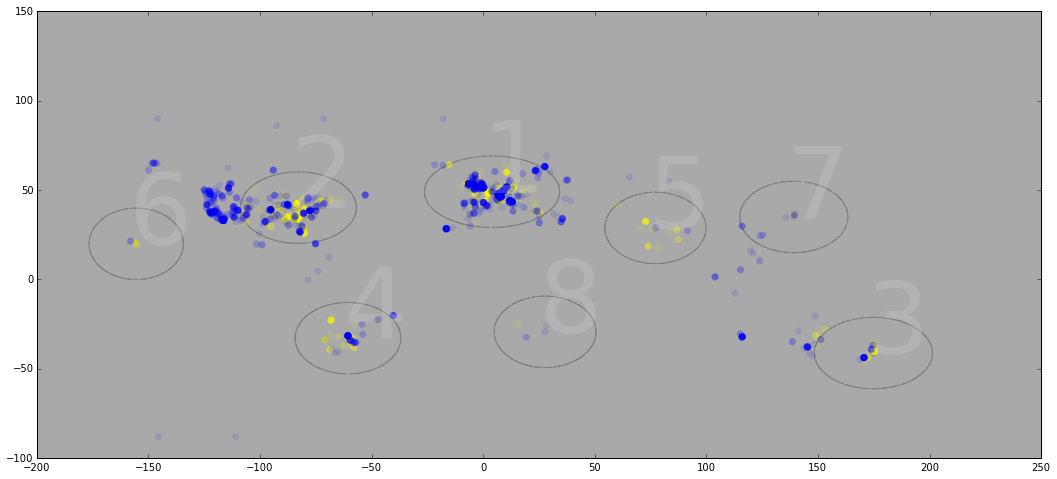

In [182]:
fig,ax = plt.subplots(figsize=(18,8))
for i, txt in enumerate(list(peaks.hotspot)):
    ax.annotate(txt, (peaks.lon.iloc[i],peaks.lat.iloc[i]), fontsize=100, color="lightgrey",alpha=0.25)
ax.scatter(all_x,all_y,s=1,c="grey",edgecolors="none")
ax.scatter(contained_x,contained_y,s=50,c="yellow",alpha=0.1,edgecolors="none")
ax.scatter(free_x,free_y,s=50,c="blue",alpha=0.1,edgecolors="none")
ax.set_axis_bgcolor('darkgrey')

Hmm. We are getting lots of errors with our spatial join here. All points said to be within a hotspot do seem pretty much within, but shapely is missing lots of contained points. The points in blue are clearly within ellipse boundaries in some cases, but if colored blue are ones shapely doesn't believe to be within any hotspot. This is obviously a problem.